# P3 submission: Loading and Preprocessing part

In [2]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from collections import Counter

# statistics
from scipy.stats import ttest_rel, ttest_ind
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore') # remove the warnings

# Load ratings.txt

We are processing data extracted from two similar beer rating websites: BeerAdvocate and RateBeer. The primary data structure is outlined in "ratings.txt," which includes user reviews providing information on beer (names, IDs, style, alcohol by volume), breweries, and users (date of review, user details, ratings, and comments on various aspects). Other supporting files include "beers.csv" (aggregated ratings for each beer), "Breweries" (information on breweries and their locations), and "Users" (user details on the number of ratings, reviews, and country of origin).

The most crucial file is "ratings.txt," as others are derived from its content. Due to its significant size (4.3 GB for BeerAdvocate and 3.95 GB for RateBeer), loading directly with a standard pipeline is impractical due to laptop memory limitations. To address this, we split the .txt files into N subfiles and load the data iteratively using a function.

The function allows control over the fraction of initial data loaded via the parameter **Nb_files**, which determines the number of subfiles to load. It also accommodates inherent differences between the two websites, such as additional review columns for BeerAdvocate.

Once loaded into DataFrames, we utilize the sample_data function to randomly sample a fraction of the data, enabling efficient handling of the substantial dataset.

In [3]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './../dataset_BeerReviews/BeerAdvocate/ratings_split_BA_new/'
    else:
        directory = './../dataset_BeerReviews/RateBeer/ratings_split_RB/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [4]:
# Load data : for faster processing, we will only load 1 file out of the whole dataset
ratings_BA = load_txt_file('BeerAdvocate', 1)
ratings_RB = load_txt_file('RateBeer', 1)

In [5]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 1)
ratings_RB = sample_data(df = ratings_RB, ratio = 1)

In [6]:
print(f"Length of ratings_BA (BeerAdvocate) dataframe : {len(ratings_BA)}")
print(f"Length of ratings_RB (RateBeer) dataframe : {len(ratings_RB)}")
display(ratings_BA.head(2),ratings_RB.head(2))

Length of ratings_BA (BeerAdvocate) dataframe : 444338
Length of ratings_RB (RateBeer) dataframe : 446795


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199,BrewDog,16315,American Double / Imperial IPA,8.2,1370426400,aztraz,aztraz.671249,nan,nan,nan,nan,nan,3.50,nan,False
121830,Tetley's English Ale,706,Carlsberg-Tetley Brewing Ltd,8535,English Pale Ale,3.6,1451041200,hockeyfighter19,hockeyfighter19.683185,4.0,3.75,3.75,4.0,3.75,3.87,nan,False


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
262500,Brew Brothers Prairie Berry Ale,21927,Brew Brothers Brewing &#40;Alberta&#41;,3033,Fruit Beer,5.5,1044615600,presario,5348,3,6,3,7,13,3.20,Big blue 1L bottle. Very loud pop announced t...
39881,Ed Hardy Premium Beer,110849,Cervecería Mexicana (Grupo Modelo),5973,Pale Lager,4.6,1281520800,Cajun,47922,2,4,2,3,5,1.60,Tasting - Gulf Brew 2010 - Pale amber white he...


### Load the other data

In [7]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

**Check the type**

In [8]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


**Change the type**

One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [11]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

In [12]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,float64
date,object,object
user_name,object,object
user_id,object,object
appearance,float64,float64


## Combine all the dataframes

- matched (already standardized, need to check scales though of numerical features)
- BA (not standardized yet)
- RB (not standardized yet)

First we need to standardize the data from ratings_BA and ratings_RB before combining them with matched (which has already been standardized per year and per website, see paper)

Explain that we duplicate the matched samples (1 from BA and 1 from RB), so that we keep all the reviews, independently of the website.

### Preprocessing : standardize ratings_BA and ratings_RB annually

- Need to add time dimension first: month and year

In [13]:
def add_time_features(df):
    """
    Adds a 'month' and a 'year' features to the DataFrame based on the 'date' column.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including a 'date' column.

    Returns
    -------
    df_m : DataFrame
        Contains the original data with an additional 'month' and 'year' features.
    """
    # Create a copy of the DataFrame
    df_time = df.copy()
    # Conversion of date feature from timestamp to text date
    pd.to_numeric(df_time['date'], errors='coerce', downcast='integer')
    # Convert 'date' to datetime and extract the date
    df_time.date = df.date.apply(lambda d: pd.to_datetime(d, unit='s'))
    df_time['date'] = df_time['date'].dt.date

    # Extract the month from the 'date' column and add it as a new feature 'month'
    df_time['month'] = pd.to_datetime(df_time['date']).dt.month
    # Extract the year from the 'date' column and add it as a new feature 'year'
    df_time['year'] = pd.to_datetime(df_time['date']).dt.year

    return df_time

In [14]:
ratings_BA_with_time = add_time_features(ratings_BA)
ratings_RB_with_time = add_time_features(ratings_RB)

In [15]:
def standardize_annually_ratings(df):
    """
    Standardizes the ratings annually and per website.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with standardized ratings with additional column 'standardized_rating'.
                
    """
    df_copy = df.copy()
    grouped = df_copy.groupby('year')['rating'].agg(['mean', 'std'])
    df_copy = pd.merge(df_copy, grouped, left_on='year', right_index=True)
    df_copy['standardized_rating'] = (df_copy['rating'] - df_copy['mean']) / df_copy['std']
    
    return df_copy, grouped

ratings_BA_standardized, mean_std_BA = standardize_annually_ratings(ratings_BA_with_time)
ratings_RB_standardized, mean_std_RB = standardize_annually_ratings(ratings_RB_with_time)

In [22]:
display(ratings_BA_standardized.head(2), ratings_RB_standardized.head(2))

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,review,month,year,mean,std,standardized_rating
43736,"Hello, My Name Is Ingrid",67199.0,BrewDog,16315.0,American Double / Imperial IPA,8.2,2013-06-05,aztraz,aztraz.671249,NaN,...,NaN,NaN,3.5,nan,False,6.0,2013.0,3.653283,0.708228,-0.216431
25783,Fraoch Heather Ale,245.0,Williams Brothers Brewing Company,12142.0,Scottish Gruit / Ancient Herbed Ale,5.0,2013-08-07,ekalb31,ekalb31.747152,NaN,...,NaN,NaN,3.5,nan,False,8.0,2013.0,3.653283,0.708228,-0.216431


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,text,month,year,mean,std,standardized_rating
262500,Brew Brothers Prairie Berry Ale,21927.0,Brew Brothers Brewing &#40;Alberta&#41;,3033.0,Fruit Beer,5.5,2003-02-07,presario,5348,3.0,...,3.0,7.0,13.0,3.2,Big blue 1L bottle. Very loud pop announced t...,2.0,2003.0,2.77721,0.946621,0.446630
421212,Maharaja Premium Indian Pilsner,96533.0,United Breweries Group,44.0,Pale Lager,5.0,2003-05-18,Slick,1522,3.0,...,2.0,5.0,10.0,2.5,"Small to no head,Nice straw color,Small amount...",5.0,2003.0,2.77721,0.946621,-0.292842


In [21]:
display(mean_std_BA.head(), mean_std_RB.head())

,mean,std
year,,
1998.0,3.916429,0.824972
1999.0,4.450000,NaN
2000.0,4.035385,0.542473
2001.0,3.917296,0.916992
2002.0,3.723361,0.782099


,mean,std
year,,
2000.0,2.823167,1.016145
2001.0,2.827134,1.077653
2002.0,2.776838,0.997550
2003.0,2.777210,0.946621
2004.0,2.808679,0.965913


In [17]:
def plot_mean_std_errorbar(grouped_BA, grouped_RB):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.errorbar(grouped_BA.index, grouped_BA['mean'], yerr=1.96 * grouped_BA['std'] / np.sqrt(grouped_BA['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'BeerAdvocate')
    plt.errorbar(grouped_RB.index, grouped_RB['mean'], yerr=1.96 * grouped_RB['std'] / np.sqrt(grouped_RB['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'RateBeer')
    plt.title('Mean Ratings across Years')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.errorbar(grouped_BA.index, grouped_BA['std'], yerr=1.96 * grouped_BA['std'] / np.sqrt(grouped_BA['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'BeerAdvocate')
    plt.errorbar(grouped_RB.index, grouped_RB['std'], yerr=1.96 * grouped_RB['std'] / np.sqrt(grouped_RB['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'RateBeer')
    plt.title('Standard Deviation of Ratings across Years')
    plt.tight_layout()
    plt.legend()
    plt.show()

Before standardization


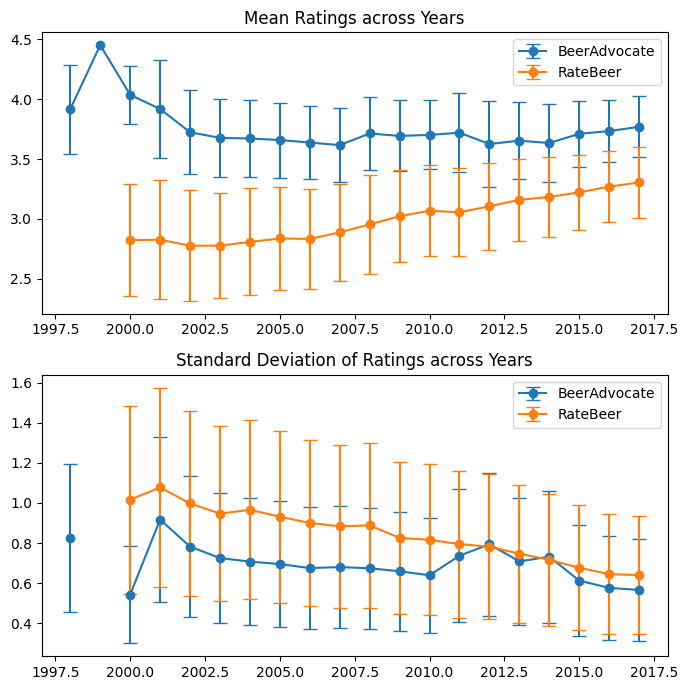

In [18]:
print("Before standardization")
plot_mean_std_errorbar(mean_std_BA, mean_std_RB)

After standardization


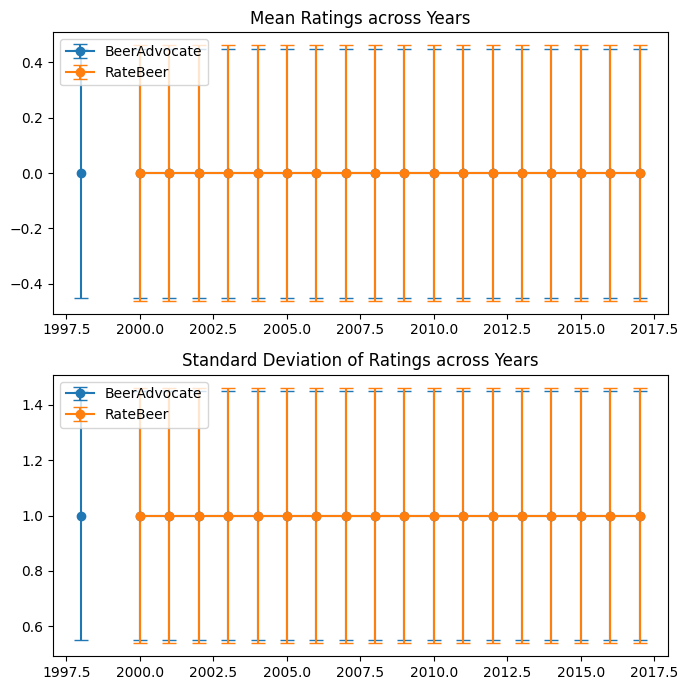

In [19]:
mean_std_BA_standardized = ratings_BA_standardized.groupby('year')['standardized_rating'].agg(['mean', 'std'])
mean_std_RB_standardized = ratings_RB_standardized.groupby('year')['standardized_rating'].agg(['mean', 'std'])
print("After standardization")
plot_mean_std_errorbar(mean_std_BA_standardized, mean_std_RB_standardized)

In [25]:
def plot_features_1df(df, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'] 
    fig, axes = plt.subplots(2, 4, figsize=(15,7))
    fig.delaxes(axes[1, 3])
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        data = df[~df[col].isna()]
        sns.histplot(data=data[col], bins=50, ax=ax) 
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_features_2df(df1, df2, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'standardized_rating']
    fig, axes = plt.subplots(2, 4, figsize=(15,7))
    #fig.delaxes(axes[1, 3])
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        sns.histplot(data=df1[~df1[col].isna()], x=col, bins=50, ax=ax, color='skyblue', alpha=0.5, label='BeerAdvocate')
        sns.histplot(data=df2[~df2[col].isna()], x=col, bins=50, ax=ax, color='salmon', alpha=0.5, label='RateBeer')
        ax.set_title(col)
        ax.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

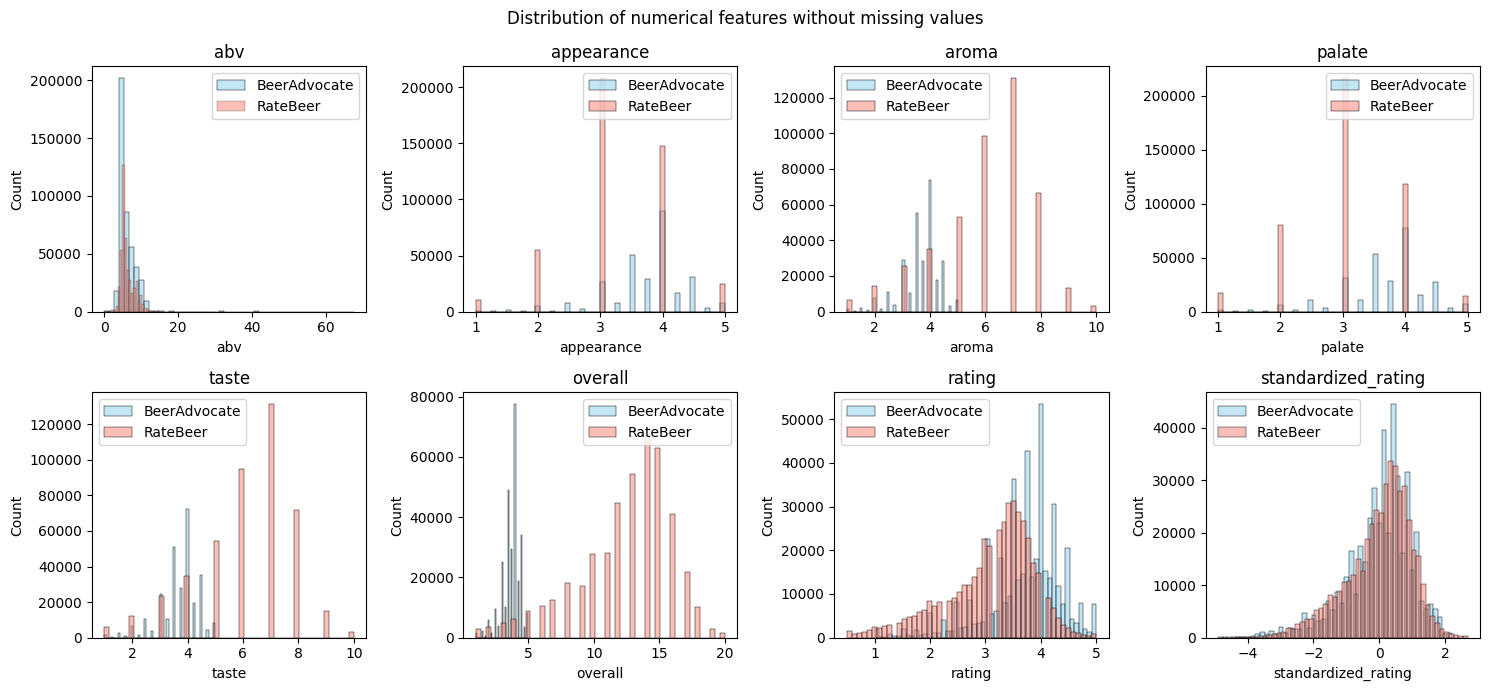

In [26]:
plot_features_2df(ratings_BA_standardized, ratings_RB_standardized, "Distribution of numerical features without missing values")

### Now combine the data with standardized ratings

In [ ]:
ratings_matched_test = ratings_matched.copy(deep=True)
ratings_matched_test['beer_id.1'] = ratings_matched_test['beer_id']
ratings_matched_test['brewery_id.1'] = ratings_matched_test['brewery_id']
ratings_matched_test['beer_name.1'] = ratings_matched_test['beer_name']
ratings_matched_test['brewery_name.1'] = ratings_matched_test['brewery_name']

ratings_matched_test_1 = ratings_matched_test.iloc[:, :17]
ratings_matched_test_1 = ratings_matched_test_1.drop(['review'], axis=1)
ratings_matched_test_2 = ratings_matched_test.iloc[:, 17:]
ratings_matched_test_2['overall.1'] = ratings_matched_test_2['overall.1']*5/20
ratings_matched_test_2['aroma.1'] = ratings_matched_test_2['aroma.1']*5/10
ratings_matched_test_2['taste.1'] = ratings_matched_test_2['taste.1']*5/10
ratings_matched_test_2.columns = ratings_matched_test_1.columns
ratings_matched_test = pd.concat([ratings_matched_test_1, ratings_matched_test_2], axis=0)
ratings_matched_test.sort_values(by=['beer_id', 'user_id'], inplace=True)

# concatenate matched data with ratings_BA and ratings_RB
all_data= pd.concat([ratings_BA,ratings_RB,ratings_matched_test], axis=0)

# test
print(f"Length of ratings matched: {len(ratings_matched)}")
print(f"Length of ratings BA: {len(ratings_BA)}")
print(f"Length of ratings RB: {len(ratings_RB)}")
print(f"Length of combined dataset: {len(all_data)}")
all_data.head(2)

**Copy paste this code until here to load and combine the dataset correctly**

### **Loading and preprocessing done**

---

# Only for descriptive statistics below

In [ ]:
def get_feature_stats(df):
        """
        Obtains descriptive statistics for all features and percentage of missing values

        Parameters
        ----------
        df : DataFrame containing all data
        
        Returns
        -------
        stats : DataFrame containing the statistics for all features.
        """
        # Calculate numerical descriptive statistics 
        numerical = df.describe(include= ['float64', 'int64'])
        # Calculate categorical descriptive statistics
        categorical = df.describe(include= ['object'])
        # Combine numerical and categorical statistics into a single DataFrame
        stats = pd.concat([numerical, categorical])
        
        # Select specific statistics for the output
        stats = stats.loc[['mean', 'std', '50%', 'unique', 'freq', 'max']]
        # Calculate the percentage of missing values for each feature
        percentage = df.isnull().sum(axis = 0)*100 / len(df)
        # Add a row to the DataFrame containing the percentage of missing values for each feature
        stats.loc['missing_values'] = np.array(percentage)
        return stats

In [ ]:
display(get_feature_stats(ratings_BA), get_feature_stats(ratings_RB))

In [ ]:
df1 = get_feature_stats(breweries_BA)
df2 = get_feature_stats(breweries_RB)
df3 = get_feature_stats(users_BA)
df4 = get_feature_stats(users_RB)

# Using HTML/CSS to display DataFrames in the same row
html = f'<div style="display: flex; flex-direction: row;"> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Breweries BeerAdvocate</h3>{df1.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 100px;"> \
                <h3>Breweries RateBeer</h3>{df2.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Users BeerAdovate</h3>{df3.to_html()} \
            </div> \
            <div style="text-align: center;"> \
                <h3>Users RateBeer</h3>{df4.to_html()} \
            </div> \
        </div>'

display(HTML(html))

In [ ]:
plot_features_1df(all_data, "Distribution of numerical features of all data combined without standardization")

In [ ]:
ratings_matched_test = ratings_matched.copy(deep=True)
ratings_matched_test['beer_id.1'] = ratings_matched_test['beer_id']
ratings_matched_test['brewery_id.1'] = ratings_matched_test['brewery_id']
ratings_matched_test['beer_name.1'] = ratings_matched_test['beer_name']
ratings_matched_test['brewery_name.1'] = ratings_matched_test['brewery_name']

ratings_matched_test_1 = ratings_matched_test.iloc[:, :17]
ratings_matched_test_1 = ratings_matched_test_1.drop(['review'], axis=1)
ratings_matched_test_2 = ratings_matched_test.iloc[:, 17:]
ratings_matched_test_2['overall.1'] = ratings_matched_test_2['overall.1']*5/20
ratings_matched_test_2['aroma.1'] = ratings_matched_test_2['aroma.1']*5/10
ratings_matched_test_2['taste.1'] = ratings_matched_test_2['taste.1']*5/10
ratings_matched_test_2.columns = ratings_matched_test_1.columns
ratings_matched_test = pd.concat([ratings_matched_test_1, ratings_matched_test_2], axis=0)
ratings_matched_test.sort_values(by=['beer_id', 'user_id'], inplace=True)
all_data= pd.concat([ratings_BA,ratings_RB,ratings_matched_test], axis=0)

# test
print(f"Length of ratings matched: {len(ratings_matched)}")
print(f"Length of ratings BA: {len(ratings_BA)}")
print(f"Length of ratings RB: {len(ratings_RB)}")
print(f"Length of combined dataset: {len(all_data)}")
all_data.head(2)

In [ ]:
plot_features_1df(all_data, "Distribution of numerical features of all data combined with standardization")

In [ ]:
plot_features_2df(ratings_matched_test_1, ratings_matched_test_2, "Distribution of numerical features without missing values")

In [ ]:
ratings_BA_standardized = standardize_numerical_data(ratings_BA)
ratings_RB_standardized = standardize_numerical_data(ratings_RB)

ratings_BA_normalized = normalize_numerical_data(ratings_BA)
ratings_RB_normalized = normalize_numerical_data(ratings_RB)

# check variances of the distributions in BA and RB
def scale_numerical_data(df):
    df_scaled = df.copy()
    df_scaled['overall'] = df_scaled['overall']/4
    df_scaled['aroma'] = df_scaled['aroma']/2
    df_scaled['taste'] = df_scaled['taste']/2
    return df_scaled

ratings_RB_scaled = scale_numerical_data(ratings_RB)

plot_features_2df(standardize_numerical_data(ratings_BA), standardize_numerical_data(ratings_RB), "Distribution of numerical features without missing values - Standardized")
plot_features_2df(normalize_numerical_data(ratings_BA), normalize_numerical_data(ratings_RB), "Distribution of numerical features without missing values - Normalized")
plot_features_2df(ratings_BA, ratings_RB_scaled, "Distribution of numerical features without missing values - scaled")

In [ ]:
#display(get_feature_stats(ratings_BA), get_feature_stats(ratings_BA_standardized), get_feature_stats(ratings_BA_normalized))

### Check hypothesis

In [ ]:
print(ratings_BA_cleaned.columns)
ratings_BA_cleaned.head(2)

In [ ]:
outcome_variables = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']  # Outcome variables

coefficients_BA = {'polarity_text': [], 'subjectivity_text': []}  # Store coefficients for each variable
p_values_BA = {'polarity_text': [], 'subjectivity_text': []}  # Store p-values for each variable

coefficients_RB = {'polarity_text': [], 'subjectivity_text': []}  # Store coefficients for each variable
p_values_RB = {'polarity_text': [], 'subjectivity_text': []}  # Store p-values for each variable

# Beer Advocate
for var in outcome_variables:
    formula = f'{var} ~ polarity_text + subjectivity_text'
    mod = smf.ols(formula=formula, data=ratings_BA_cleaned)
    res = mod.fit()
    
    # Store coefficients and p-values
    coefficients_BA['polarity_text'].append(res.params['polarity_text'])
    coefficients_BA['subjectivity_text'].append(res.params['subjectivity_text'])
    p_values_BA['polarity_text'].append(res.pvalues['polarity_text'])
    p_values_BA['subjectivity_text'].append(res.pvalues['subjectivity_text'])
    
# Rate Beer
for var in outcome_variables:
    formula = f'{var} ~ polarity_text + subjectivity_text'
    mod = smf.ols(formula=formula, data=ratings_RB_cleaned)
    res = mod.fit()
    
    # Store coefficients and p-values
    coefficients_RB['polarity_text'].append(res.params['polarity_text'])
    coefficients_RB['subjectivity_text'].append(res.params['subjectivity_text'])
    p_values_RB['polarity_text'].append(res.pvalues['polarity_text'])
    p_values_RB['subjectivity_text'].append(res.pvalues['subjectivity_text'])

# Display results
for i, var in enumerate(outcome_variables):
    print("###### Beer Advocate #####")
    print(f"Variable: {var}")
    print(f"Coefficient for polarity_text: {coefficients_BA['polarity_text'][i]:.4f}, p-value: {p_values_BA['polarity_text'][i]:.4f}")
    print(f"Coefficient for subjectivity_text: {coefficients_BA['subjectivity_text'][i]:.4f}, p-value: {p_values_BA['subjectivity_text'][i]:.4f}")
    print("=" * 30)
    
for i, var in enumerate(outcome_variables):
    print("###### Rate Beer #####")
    print(f"Variable: {var}")
    print(f"Coefficient for polarity_text: {coefficients_RB['polarity_text'][i]:.4f}, p-value: {p_values_RB['polarity_text'][i]:.4f}")
    print(f"Coefficient for subjectivity_text: {coefficients_RB['subjectivity_text'][i]:.4f}, p-value: {p_values_RB['subjectivity_text'][i]:.4f}")
    print("=" * 30)

# Plotting coefficients
fig, axs = plt.subplots(1,2, figsize = (12,4))

axs[0].barh(outcome_variables, coefficients_BA['polarity_text'], label='polarity_text', color='skyblue')
axs[0].barh(outcome_variables, coefficients_BA['subjectivity_text'], label='subjectivity_text', color='orange', alpha=0.6)
axs[0].set_xlabel('Coefficients')
axs[0].set_title('Linear Regression Coefficients Beer Advocate')

axs[1].barh(outcome_variables, coefficients_RB['polarity_text'], label='polarity_text', color='skyblue')
axs[1].barh(outcome_variables, coefficients_RB['subjectivity_text'], label='subjectivity_text', color='orange', alpha=0.6)
axs[1].set_xlabel('Coefficients')
axs[1].set_title('Linear Regression Coefficients Rate Beer')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Plotting coefficients
fig, ax = plt.subplots(figsize=(12, 4))

# Define bar positions for each outcome variable
bar_width = 0.35
bar_positions1 = np.arange(len(outcome_variables))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

# Plot Beer Advocate coefficients
ax.barh(bar_positions1, coefficients_BA['polarity_text'], label='BA - polarity_text', color='blue', height=bar_width)
ax.barh(bar_positions1, coefficients_BA['subjectivity_text'], label='BA - subjectivity_text', color='blue', alpha=0.6, height=bar_width)

# Plot Rate Beer coefficients
ax.barh(bar_positions2, coefficients_RB['polarity_text'], label='RB - polarity_text', color='green', height=bar_width)
ax.barh(bar_positions2, coefficients_RB['subjectivity_text'], label='RB - subjectivity_text', color='green', alpha=0.6, height=bar_width)

ax.set_yticks((np.array(bar_positions1) + np.array(bar_positions2)) / 2)
ax.set_yticklabels(outcome_variables)
ax.set_xlabel('Coefficients')
ax.set_title('Linear Regression Coefficients Comparison')

plt.legend()
plt.tight_layout()
plt.show()

### Detect outliers in polarity and subjectivity

2 approaches:
- take the best scores and look at their polarity and subjectivity
- take the extreme polarity and subjectivity and look at their scores (per review or per reviewer ?)

In [ ]:
# Calculate the 95th percentile of 'rating'
df = ratings_BA_cleaned
rating_95th_percentile = df['rating'].quantile(0.95)
print(rating_95th_percentile)

# Filter rows where 'rating' is not in the 95% interval
filtered_df = df[df['rating'] < rating_95th_percentile]

# Plot the distribution of 'polarity_text'
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['polarity_text'], bins=20, color='skyblue')
plt.title('Distribution of polarity_text (Filtered by Rating)')
plt.xlabel('Polarity Text')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
from scipy.stats import norm
from scipy.stats import normaltest
# Plotting the histogram of 'rating'
sns.histplot(ratings_BA_cleaned['rating'], kde=True, stat='density')

# Assuming 'data' is your dataset column (e.g., 'ratings_BA_cleaned['rating']')
data = ratings_BA_cleaned['rating']

# Perform the normality test
statistic, p_value = normaltest(data)
print(f"p-value: {p_value}")

# Assess the results
if p_value < 0.05:
    print("The data does not appear to be normally distributed.")
else:
    print("The data seems to follow a normal distribution.")

In [ ]:
print(len(ratings_BA))
print(len(ratings_BA.reset_index()['beer_name'].unique()))
print(len(ratings_BA[ratings_BA['beer_id'].isnull()]))
print(len(ratings_BA[ratings_BA['beer_name'].isnull()]))
print(len(ratings_BA.reset_index()['beer_id'].unique()))
ratings_BA.head(2)

In [ ]:
test = pd.DataFrame()
test['beer_id'] = ratings_BA.reset_index().groupby("beer_name").apply(lambda x: x['beer_id'])
#print(test['beer_name'][:50].values)
test.head()

In [ ]:
ratings_BA[ratings_BA['beer_name'] == '01|06 Saison (Motueka & Lime)'].head()

In [ ]:
ratings_BA[ratings_BA['beer_id'] == 19.0].groupby('beer_name').apply(lambda x: pd.Series({"beer_id": x['beer_id']})).head()

## Ranking baseline for breweries

- moyenne des rankings pr chq biere produite par la brewery
score = appearance	aroma	palate	taste	overall	rating

output : trouver la meilleure brewery
- plots descriptif de la meilleure brewery

plot de la distribution des sentiments 


3 blocs sur le site:
- ranking initiale
- analyse des textes
- ranking augmenté avec texte

In [ ]:
print(len(ratings_BA['brewery_id'].unique()))
print(len(ratings_BA['brewery_name'].unique()))

In [ ]:
breweries_BA_copy = breweries_BA.copy().set_index("id")

breweries_BA_copy.head()

In [ ]:
ranking_overall = ratings_BA.groupby("brewery_name").apply(lambda x: pd.Series({"avg_score": x["overall"].mean(),
                                                                                "location": breweries_BA_copy.loc[x["brewery_id"]]['location'].values})).reset_index()

ranking_overall = ranking_overall.sort_values(by='avg_score', ascending=False)
ranking_overall.head()